Parameters study

Train#=70 Test#=30
Labels=[1. 0.]
RF best for 100 trees (d=2 and f=0.1)


<Figure size 600x450 with 0 Axes>

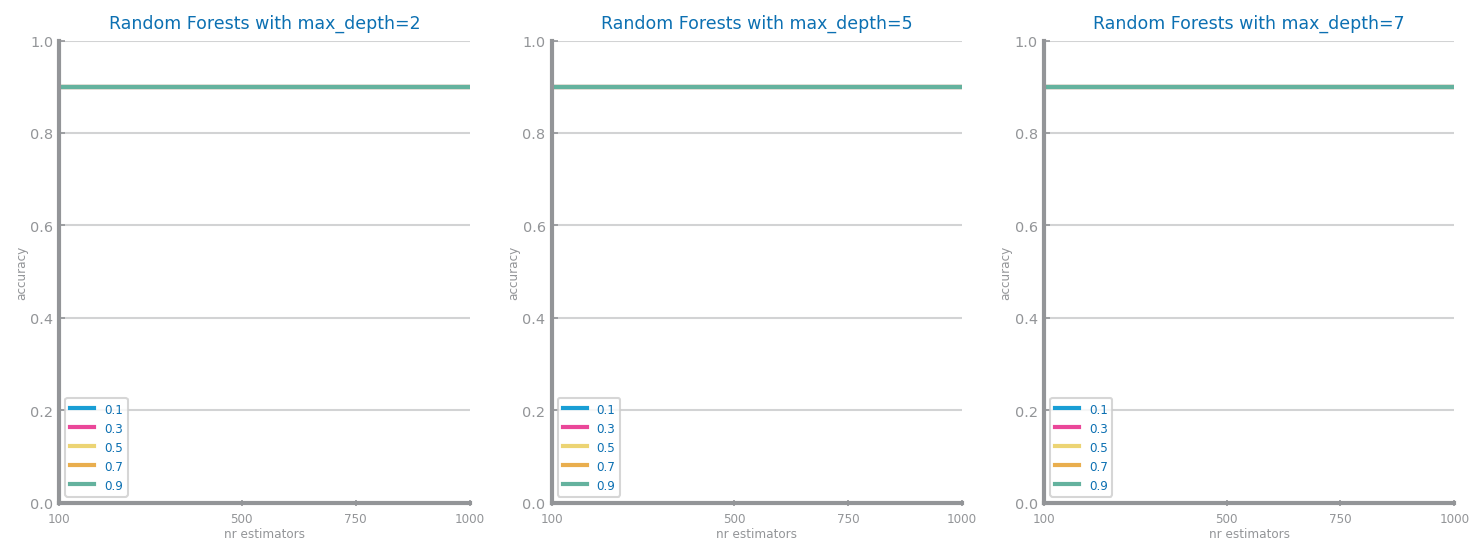

In [5]:
from numpy import array, ndarray
from matplotlib.pyplot import subplots, figure, savefig, show
from sklearn.ensemble import RandomForestClassifier
from dslabs_functions import (
    CLASS_EVAL_METRICS,
    DELTA_IMPROVE,
    read_train_test_from_files,
)
from dslabs_functions import HEIGHT, plot_evaluation_results, plot_multiline_chart

from typing import Literal
from numpy import array, ndarray
from matplotlib.pyplot import subplots, figure, savefig, show
from sklearn.neural_network import MLPClassifier
from dslabs_functions import (
    CLASS_EVAL_METRICS,
    DELTA_IMPROVE,
    read_train_test_from_files,
)
from dslabs_functions import HEIGHT, plot_evaluation_results, plot_multiline_chart
from dslabs_functions import get_variable_types
from seaborn import heatmap
from dslabs_functions import HEIGHT, plot_multi_scatters_chart
from matplotlib.pyplot import figure, subplots, savefig, show, gcf
from dslabs_functions import plot_bar_chart
from dslabs_functions import set_chart_labels
from dslabs_functions import define_grid, HEIGHT
from matplotlib.figure import Figure
from numpy import ndarray
from dslabs_functions import *
from pandas import read_csv, DataFrame
from numpy import log
from pandas import Series
from scipy.stats import norm, expon, lognorm
from matplotlib.axes import Axes
from dslabs_functions import plot_multiline_chart
import pandas as pd
from sklearn.model_selection import train_test_split


def random_forests_study(
    trnX: ndarray,
    trnY: array,
    tstX: ndarray,
    tstY: array,
    nr_max_trees: int = 2500,
    lag: int = 500,
    metric: str = "accuracy",
) -> tuple[RandomForestClassifier | None, dict]:
    n_estimators: list[int] = [100] + [i for i in range(500, nr_max_trees + 1, lag)]
    max_depths: list[int] = [2, 5, 7]
    max_features: list[float] = [0.1, 0.3, 0.5, 0.7, 0.9]

    best_model: RandomForestClassifier | None = None
    best_params: dict = {"name": "RF", "metric": metric, "params": ()}
    best_performance: float = 0.0

    values: dict = {}

    cols: int = len(max_depths)
    _, axs = subplots(1, cols, figsize=(cols * HEIGHT, HEIGHT), squeeze=False)
    for i in range(len(max_depths)):
        d: int = max_depths[i]
        values = {}
        for f in max_features:
            y_tst_values: list[float] = []
            for n in n_estimators:
                clf = RandomForestClassifier(
                    n_estimators=n, max_depth=d, max_features=f
                )
                clf.fit(trnX, trnY)
                prdY: array = clf.predict(tstX)
                eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
                y_tst_values.append(eval)
                if eval - best_performance > DELTA_IMPROVE:
                    best_performance = eval
                    best_params["params"] = (d, f, n)
                    best_model = clf
                # print(f'RF d={d} f={f} n={n}')
            values[f] = y_tst_values
        plot_multiline_chart(
            n_estimators,
            values,
            ax=axs[0, i],
            title=f"Random Forests with max_depth={d}",
            xlabel="nr estimators",
            ylabel=metric,
            percentage=True,
        )
    print(
        f'RF best for {best_params["params"][2]} trees (d={best_params["params"][0]} and f={best_params["params"][1]})'
    )
    return best_model, best_params

eval_metric = "accuracy"

results = "csv-results/credit-score-after-preparation.csv"
file_tag = "credit_score"
data: DataFrame = read_csv(results, index_col="ID")
data_to_split = data.copy()

# Split train/test


target = 'Credit_Score'
y = data_to_split[target]
X = data_to_split.drop(columns = target)
trnX, tstX, trnY, tstY = train_test_split(X, y, test_size=0.3)
train = pd.concat([trnX, trnY], axis=1)
test = pd.concat([tstX, tstY], axis=1)

labels = data.Credit_Score.unique()

vars = data.columns.to_list()
vars.remove('Credit_Score')


print(f"Train#={len(trnX)} Test#={len(tstX)}")
print(f"Labels={labels}")

figure()
best_model, params = random_forests_study(
    trnX,
    trnY,
    tstX,
    tstY,
    nr_max_trees=1000,
    lag=250,
    metric=eval_metric,
)
savefig(f"images/{file_tag}_rf_{eval_metric}_study.png")
show()

Best model performance

<Figure size 600x450 with 0 Axes>

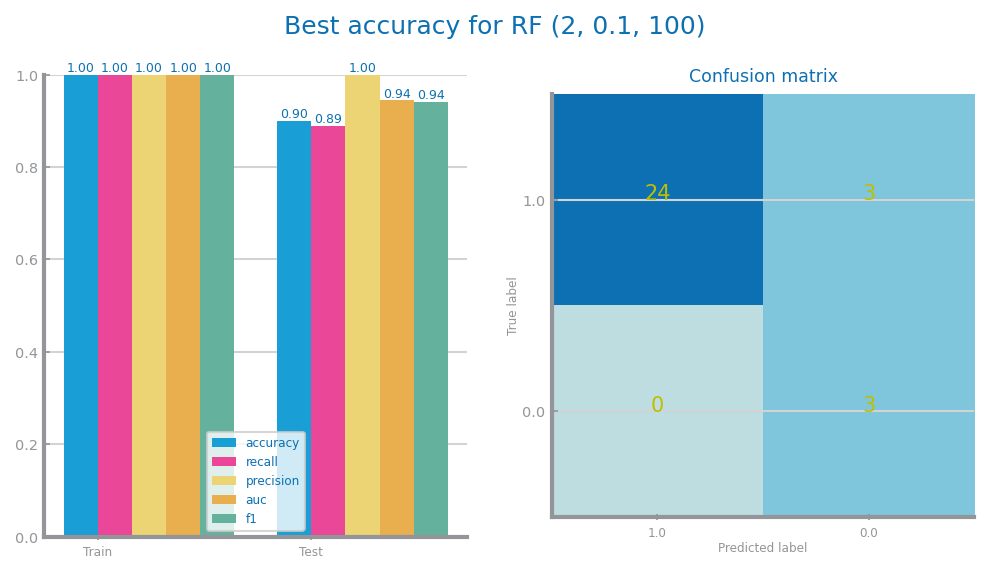

In [6]:
prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f'images/{file_tag}_rf_{params["name"]}_best_{params["metric"]}_eval.png')
show()

Vars ranking

1. Num_Bank_Accounts (0.15832329158952857)
2. ChangedCreditLimit (0.13974549940802825)
3. Delay_from_due_date (0.13955197242738546)
4. OutstandingDebt (0.0803099928232484)
5. Num_Credit_Card (0.07671085654628734)
6. Interest_Rate (0.05038336856160487)
7. Credit_History_Age_Months (0.035996800419890826)
8. Occupation_Number (0.03367040680525905)
9. CreditUtilizationRatio (0.03215308132652808)
10. Loan_Type_Student_Loan (0.031722894894250404)
11. NumCreditInquiries (0.030162047144768122)
12. Monthly_Inhand_Salary (0.029506187233681324)
13. NumofDelayedPayment (0.02841371001224255)
14. MonthlyBalance (0.01946168405265379)
15. Loan_Type_Personal_Loan (0.01776802200980356)
16. Amountinvestedmonthly (0.01591998388427081)
17. TotalEMIpermonth (0.012520958446041097)
18. Loan_Type_Not_Specified (0.010617643489867734)
19. Loan_Type_Auto_Loan (0.010018798804588835)
20. Customer_ID (0.009278897136797455)
21. Payment_Behaviour_Value (0.008566042182160954)
22. Annual_Income (0.00824790856604218)
23.

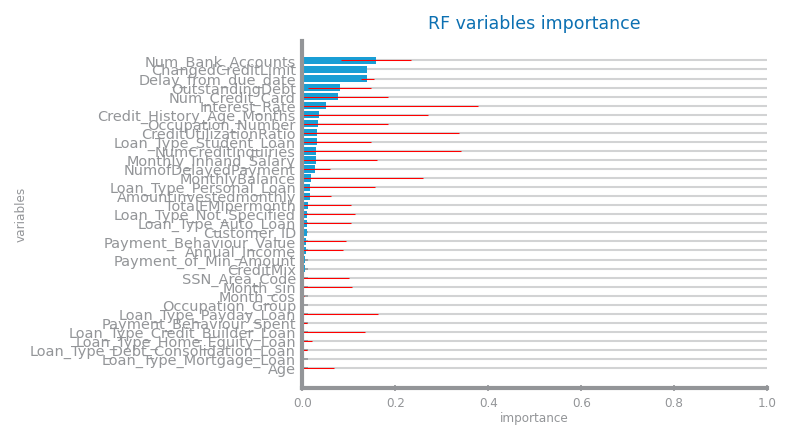

In [7]:
from numpy import std, argsort
from dslabs_functions import plot_horizontal_bar_chart

stdevs: list[float] = list(
    std([tree.feature_importances_ for tree in best_model.estimators_], axis=0)
)
importances = best_model.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values.append(importances[indices[f]])
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure()
plot_horizontal_bar_chart(
    elems,
    imp_values,
    error=stdevs,
    title="RF variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig(f"images/{file_tag}_rf_{eval_metric}_vars_ranking.png")

Overfitting

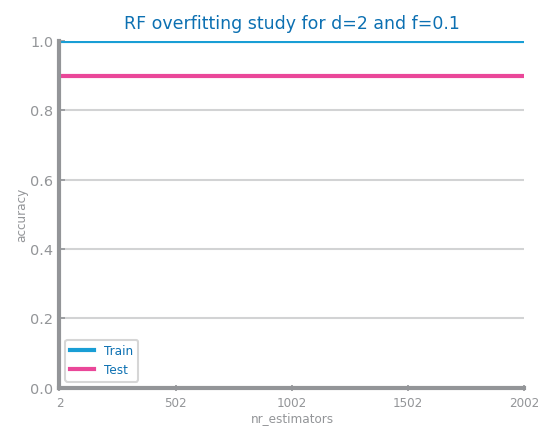

In [8]:
d_max: int = params["params"][0]
feat: float = params["params"][1]
nr_estimators: list[int] = [i for i in range(2, 2501, 500)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric: str = "accuracy"

for n in nr_estimators:
    clf = RandomForestClassifier(n_estimators=n, max_depth=d_max, max_features=feat)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    nr_estimators,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"RF overfitting study for d={d_max} and f={feat}",
    xlabel="nr_estimators",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}_rf_{eval_metric}_overfitting.png")